In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import tensorflow as tf  
from sklearn.model_selection import TimeSeriesSplit 
#print('Imported tensorflow', tf.VERSION)

In [2]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
#data = pd.read_csv('/Users/Apple/Desktop/DataX/DeepVuproject/resupplychainoptimizationdataxprojectteam/metals_daily_train.csv', index_col='date')
#data = data.dropna(axis = 0).drop('week',axis=1).drop('week_date', axis=1)
#data.head()

In [4]:
data = pd.read_csv('median_values.csv',index_col='week')
data = data.dropna(axis = 0).drop('week.1', axis=1)
data.head()

,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,...,f135_low,f135_settle,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle
week,,,,,,,,,,,,,,,,,,,,,
2030,447.084228,471.922241,459.503235,55.990,56.720,54.68,56.29,51.800,53.020,51.21,...,9850.0,10050.0,9480.0,9580.0,9315.0,9500.0,9520.0,9690.0,9495.0,9590.0
2031,447.650117,472.134908,459.710305,55.160,55.650,54.14,54.67,53.360,53.770,52.59,...,8955.0,9280.0,9200.0,9300.0,8955.0,9135.0,9270.0,9375.0,9010.0,9170.0
2032,449.842555,493.223915,459.839056,52.620,53.800,51.33,52.07,50.720,51.080,49.44,...,9705.0,9950.0,9280.0,9375.0,9215.0,9315.0,9185.0,9330.0,9175.0,9270.0
2033,461.764352,499.204704,468.004411,45.251,46.260,44.80,45.62,45.064,46.010,44.86,...,10200.0,10345.0,9735.0,9836.0,9676.0,9750.0,9720.0,9785.0,9590.0,9705.0
2034,478.104856,506.365603,489.493110,45.100,46.492,44.48,44.72,44.220,44.782,43.18,...,10543.0,10610.0,9815.0,9951.0,9748.0,9815.0,9758.0,9996.0,9688.0,9778.0


In [5]:
def df_shift(df, lag, predict_name_column):
    ### takes a data frame, shifts column to be predicted by a lag ###
    columns_features = list(df.columns)
    columns_features.remove(predict_name_column)
    
    value_to_predict = df.loc[:,predict_name_column]   
    df_shifted = df.copy()
                              
    #df_shifted = pd.DataFrame(index = df.index[lag:]
    
    
    for col in columns_features:
        df_shifted[col] = data.loc[:,col].shift(lag)
    
    
    df_shifted = df_shifted.dropna(axis=0)                        
    return df_shifted
        


In [6]:
## TEST

df_shift(data,2,'p1').head()


,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,...,f135_low,f135_settle,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle
week,,,,,,,,,,,,,,,,,,,,,
2032,447.084228,493.223915,459.503235,55.990,56.720,54.68,56.29,51.800,53.020,51.21,...,9850.0,10050.0,9480.0,9580.0,9315.0,9500.0,9520.0,9690.0,9495.0,9590.0
2033,447.650117,499.204704,459.710305,55.160,55.650,54.14,54.67,53.360,53.770,52.59,...,8955.0,9280.0,9200.0,9300.0,8955.0,9135.0,9270.0,9375.0,9010.0,9170.0
2034,449.842555,506.365603,459.839056,52.620,53.800,51.33,52.07,50.720,51.080,49.44,...,9705.0,9950.0,9280.0,9375.0,9215.0,9315.0,9185.0,9330.0,9175.0,9270.0
2035,461.764352,519.061761,468.004411,45.251,46.260,44.80,45.62,45.064,46.010,44.86,...,10200.0,10345.0,9735.0,9836.0,9676.0,9750.0,9720.0,9785.0,9590.0,9705.0
2036,478.104856,518.909889,489.493110,45.100,46.492,44.48,44.72,44.220,44.782,43.18,...,10543.0,10610.0,9815.0,9951.0,9748.0,9815.0,9758.0,9996.0,9688.0,9778.0


In [7]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    # get the index after which test set starts
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [8]:
def plotModelResultsTrain(model, X_train):
    """
        Plots modelled vs fact for train test 
    
    """
    
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_train.values, label="actual", linewidth=2.0)
        
    
    error = mean_absolute_percentage_error(y_train,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [9]:
def plotModelResultsTest(model, X_test, Y_test):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(Y_test.values, label="actual", linewidth=2.0)
    
    error = mean_absolute_percentage_error(Y_test,prediction)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [10]:
def plotFuture(model, X_train):
    """
        Plots prediction
    
    """
    
    prediction = model.predict(X_train)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    
    plt.title("Predicted stock price for 10 weeks in the future")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);

In [11]:
shift = 10

In [12]:
## shift data set by timelag

data_shifted = df_shift(data, shift, 'p1')
data_shifted.head()

,p0,p1,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,...,f135_low,f135_settle,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle
week,,,,,,,,,,,,,,,,,,,,,
2040,447.084228,506.095072,459.503235,55.990,56.720,54.68,56.29,51.800,53.020,51.21,...,9850.0,10050.0,9480.0,9580.0,9315.0,9500.0,9520.0,9690.0,9495.0,9590.0
2041,447.650117,481.102722,459.710305,55.160,55.650,54.14,54.67,53.360,53.770,52.59,...,8955.0,9280.0,9200.0,9300.0,8955.0,9135.0,9270.0,9375.0,9010.0,9170.0
2042,449.842555,468.771036,459.839056,52.620,53.800,51.33,52.07,50.720,51.080,49.44,...,9705.0,9950.0,9280.0,9375.0,9215.0,9315.0,9185.0,9330.0,9175.0,9270.0
2043,461.764352,443.542866,468.004411,45.251,46.260,44.80,45.62,45.064,46.010,44.86,...,10200.0,10345.0,9735.0,9836.0,9676.0,9750.0,9720.0,9785.0,9590.0,9705.0
2044,478.104856,449.816250,489.493110,45.100,46.492,44.48,44.72,44.220,44.782,43.18,...,10543.0,10610.0,9815.0,9951.0,9748.0,9815.0,9758.0,9996.0,9688.0,9778.0


In [13]:
## save last lagged values for future prediction
X_future = data.copy().drop('p1', axis=1).iloc[-shift:,:]
X_future.head()

,p0,p2,f000_open,f000_high,f000_low,f000_settle,f001_open,f001_high,f001_low,f001_settle,...,f135_low,f135_settle,f136_open,f136_high,f136_low,f136_settle,f137_open,f137_high,f137_low,f137_settle
week,,,,,,,,,,,,,,,,,,,,,
2514,543.083094,547.421944,16.700,17.120,16.220,16.725,17.050,17.400,16.650,17.125,...,12610.0,12690.0,24980.0,25240.0,24775.0,25040.0,24950.0,25220.0,24700.0,24980.0
2515,540.812305,540.812305,17.350,18.630,17.050,17.475,17.450,18.250,17.080,17.475,...,12075.0,12190.0,24835.0,24975.0,24500.0,24785.0,24800.0,24980.0,24475.0,24745.0
2516,518.789269,527.613209,20.005,20.509,18.792,19.700,19.327,19.639,18.386,19.115,...,11020.0,11161.0,24873.0,25018.0,24660.0,24872.0,24848.0,24982.0,24622.0,24816.0
2517,538.575901,532.448944,19.800,20.870,19.150,19.675,19.270,20.020,18.800,19.175,...,11120.0,11275.0,24910.0,25045.0,24695.0,24905.0,24865.0,24990.0,24635.0,24845.0
2518,539.844112,545.167542,19.500,19.900,19.120,19.425,19.270,19.450,18.820,19.075,...,11155.0,11220.0,24640.0,24655.0,24315.0,24495.0,24525.0,24575.0,24180.0,24370.0


In [14]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

y = data_shifted.p1
x = data_shifted.drop('p1', axis=1)

X_train, X_test, y_train, y_test = timeseries_train_test_split(x, y, test_size=shift/data_shifted.shape[0])

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [15]:
X_test_scaled.shape

(10, 554)

In [16]:
xgb = XGBRegressor()

In [17]:
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

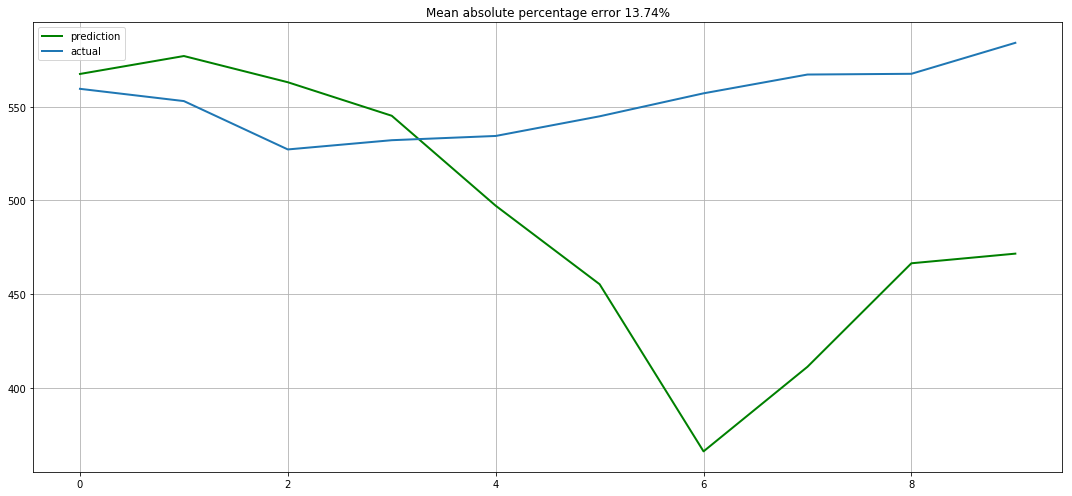

In [18]:
plotModelResultsTest(xgb, X_test=X_test_scaled, Y_test=y_test)

### Predict Future Values

In [19]:
## plot performance on whole data 

X_train, X_test, y_train, y_test = timeseries_train_test_split(x, y, test_size=0)

X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.fit_transform(X_test)

xgb = XGBRegressor()

xgb.fit(X_train_scaled, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

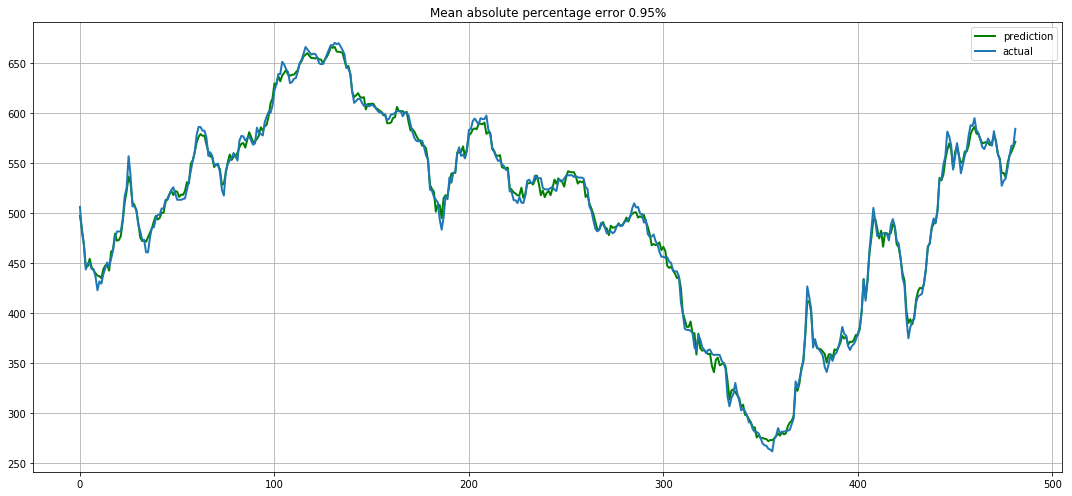

In [20]:
plotModelResultsTrain(xgb, X_train_scaled)

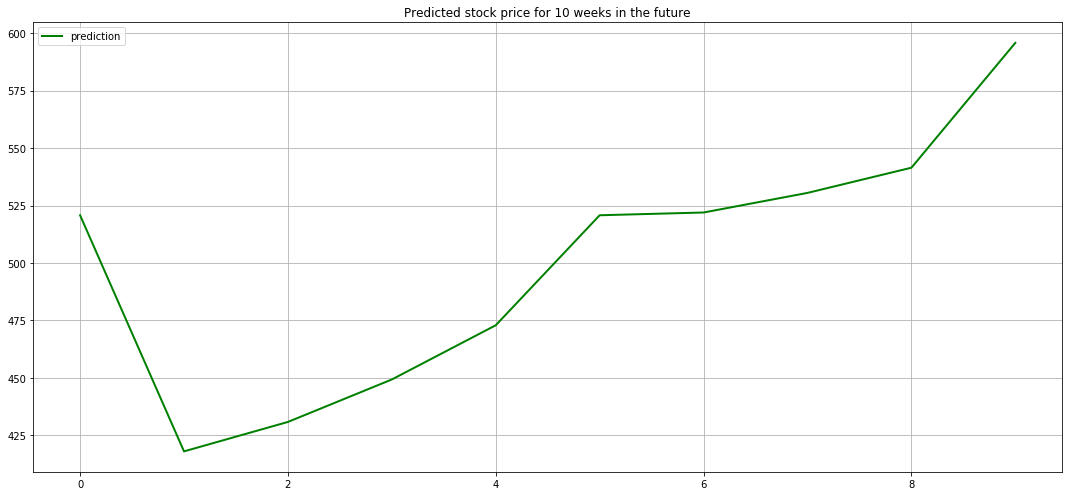

In [21]:
## predict future values and plot performance

X_future_scaled = scaler.fit_transform(X_future)

plotFuture(xgb, X_train=X_future_scaled)